In [3]:
!pip install -q torchinfo thop captum h5py

In [1]:
import os
import math
import random
from collections import defaultdict, Counter
from typing import List, Optional

import h5py
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import time
from thop import profile, clever_format
from captum.attr import Lime, IntegratedGradients
import torch.nn.functional as F


/home/ara/mim/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
# -------------------------
# Config
# -------------------------
PATH = r"C:\Users\oladipea\Documents\MIMIC-HAN\records"
SAMPLING_RATE = 500
PRE_PEAK_SAMPLES = 99
POST_PEAK_SAMPLES = 201
SEGMENT_LENGTH = PRE_PEAK_SAMPLES + POST_PEAK_SAMPLES  # 300
BATCH_SIZE = 16
DROP_LAST = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# utilities: filtering and peak detection
# -------------------------
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def pan_tompkins_detector(ecg_signal, fs):
    lowcut, highcut = 5.0, 15.0
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    diff_ecg = np.diff(filtered_ecg)
    squared_ecg = diff_ecg ** 2
    window_size = int(0.150 * fs)
    mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')
    peaks, _ = find_peaks(mwa_ecg, distance=int(0.6 * fs))
    return peaks


def multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=None):
    n_leads = len(detected_peaks)
    if min_leads is None:
        min_leads = int(np.ceil(n_leads / 2))

    # Collect all peaks with their lead information
    all_peaks = [(p, lead) for lead, peaks in enumerate(detected_peaks) for p in peaks]
    all_peaks.sort(key=lambda x: x[0])

    fused_peaks = []
    i = 0

    while i < len(all_peaks):
        # Start a new cluster
        cluster = [all_peaks[i]]
        i += 1

        # Add nearby peaks to the cluster
        while i < len(all_peaks) and all_peaks[i][0] - cluster[-1][0] <= fusion_window * fs:
            cluster.append(all_peaks[i])
            i += 1

        # Check if cluster has peaks from enough leads
        unique_leads = {lead for _, lead in cluster}
        if len(unique_leads) >= min_leads:
            # Use median position as the fused peak
            fused_peak = int(np.median([p for (p, _) in cluster]))
            fused_peaks.append(fused_peak)

    return np.array(sorted(fused_peaks))


def detect_r_peaks(ecg_signals, fs):
    detected_peaks = []
    for lead in ecg_signals:
        peaks = pan_tompkins_detector(lead, fs)
        detected_peaks.append(peaks)

    fused_r_peaks = multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=6)
    return fused_r_peaks


def extract_segments_around_peaks(signal, r_peaks, pre_samples, post_samples):
    segments = []

    for peak in r_peaks:
        start = max(0, peak - pre_samples)
        end = min(len(signal), peak + post_samples)

        # Only include segments with the correct length
        if end - start == pre_samples + post_samples:
            segment = signal[start:end]
            segments.append(segment)

    return segments

def extract_beats_multi_lead(ecg_signals, fs, pre_samples, post_samples, denoise_fn=None):
    # Convert to numpy array for consistent indexing
    ecg_signals = np.array(ecg_signals)

    # Apply denoising if provided
    if denoise_fn is not None:
        ecg_signals = np.array([denoise_fn(lead) for lead in ecg_signals])

    # Detect fused R-peaks across all leads
    r_peaks = detect_r_peaks(ecg_signals, fs)
    # print(f"Detected {len(r_peaks)} R-peaks after fusion")

    if len(r_peaks) == 0:
        return None

    # Extract segments from all leads
    all_lead_segments = []
    for lead_idx, lead_signal in enumerate(ecg_signals):
        segments = extract_segments_around_peaks(lead_signal, r_peaks, pre_samples, post_samples)
        all_lead_segments.append(segments)

    # Find the minimum number of valid segments across all leads
    min_segments = min(len(segments) for segments in all_lead_segments)
    # print(f"Extracted {min_segments} valid segments across all leads")

    if min_segments == 0:
        return None

    # Stack segments: (n_beats, segment_length, n_leads)
    beats_arr = np.stack([
        np.stack(segments[:min_segments], axis=0)
        for segments in all_lead_segments
    ], axis=-1)

    return beats_arr.astype(np.float32)

In [4]:
samples = np.load(r"atrial_fibrillation.npy", allow_pickle=True)

In [5]:
# @title
# -------------------------
# Attention / helper layers
# -------------------------
class ChannelAttention(nn.Module):
    """
    Expects x shape = (batch, channels, seq_len)
    """
    def __init__(self, channels, ratio=8):
        super().__init__()
        mid = max(1, channels // ratio)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=True),
            nn.ReLU(),
            nn.Linear(mid, channels, bias=True)
        )

    def forward(self, x):
        # x: (B, C, L)
        avg_pool = torch.mean(x, dim=2)           # (B, C)
        max_pool, _ = torch.max(x, dim=2)         # (B, C)
        avg_out = self.mlp(avg_pool)              # (B, C)
        max_out = self.mlp(max_pool)              # (B, C)
        att = torch.sigmoid(avg_out + max_out)    # (B, C)
        att = att.unsqueeze(2)                    # (B, C, 1)
        return x * att                             # broadcast multiply -> (B, C, L)


class SegmentAttention(nn.Module):
    """
    Input: (batch, time_steps, input_dim)
    Produces: (batch, input_dim), (batch, time_steps)  (output vector, alphas)
    `units` is the hidden size of the attention MLP (same as original design).
    """
    def __init__(self, input_dim, units):
        super().__init__()
        self.linear = nn.Linear(input_dim, units, bias=True)  # W and b equivalent
        # u vector for scoring
        self.u = nn.Parameter(torch.randn(units))

    def forward(self, inputs):
        # inputs: (B, T, D)
        v = torch.tanh(self.linear(inputs))           # (B, T, units)
        # score each time step
        vu = torch.matmul(v, self.u)                  # (B, T)
        alphas = F.softmax(vu, dim=1)                 # softmax over time dimension
        output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)  # (B, D)
        return output, alphas


class TimeDistributedSegmentAttention(nn.Module):
    """
    inputs: (B, segments, seg_len, feature_dim)
    returns: (B, segments, feature_dim), (B, segments, seg_len)
    """
    def __init__(self, input_dim, units):
        super().__init__()
        self.segment_attention = SegmentAttention(input_dim, units)

    def forward(self, inputs):
        # inputs: (B, S, T, D)
        B, S, T, D = inputs.shape
        flat = inputs.view(B * S, T, D)                       # (B*S, T, D)
        outputs, alphas = self.segment_attention(flat)        # (B*S, D), (B*S, T)
        outputs = outputs.view(B, S, D)                       # (B, S, D)
        alphas = alphas.view(B, S, T)                         # (B, S, T)
        return outputs, alphas


class HANWithAttention(nn.Module):
    def __init__(
        self,
        num_classes,
        conv_channels=128,
        segment_hidden=256,
        sequence_hidden=512,
        fc_hidden=2048,
        dropout=0.4,
    ):
        super().__init__()

        # 1D conv over 12 leads
        self.conv1d = nn.Conv1d(12, conv_channels, kernel_size=25, padding=12)
        self.channel_attention = ChannelAttention(conv_channels, ratio=8)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Beat-level LSTM
        self.lstm_segment = nn.LSTM(
            input_size=conv_channels,
            hidden_size=segment_hidden,
            batch_first=True
        )
        self.time_distributed_attention = TimeDistributedSegmentAttention(
            segment_hidden,
            segment_hidden
        )

        # Sequence-level LSTM
        self.lstm_sequence = nn.LSTM(
            input_size=segment_hidden,
            hidden_size=sequence_hidden,
            batch_first=True
        )
        self.final_attention = SegmentAttention(sequence_hidden, sequence_hidden)

        self.fc = nn.Linear(sequence_hidden, fc_hidden)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(fc_hidden, num_classes)

    def forward(self, x):
        logits, _, _ = self.forward_with_attention(x)
        return logits

    def forward_with_attention(self, x):
        # x: (B, S, T, C) = (batch, beats, time, leads)
        B, S, T, C = x.shape

        # process beats individually: (B*S, C, T)
        x = x.view(B * S, T, C).permute(0, 2, 1)

        conv = self.conv1d(x)
        att  = self.channel_attention(conv)
        pooled = self.pool(att).permute(0, 2, 1)     # (B*S, T2, conv_channels)

        seg_out, _ = self.lstm_segment(pooled)       # (B*S, T2, segment_hidden)

        # regroup beats: (B, S, T2, segment_hidden)
        seg_out = seg_out.view(B, S, seg_out.shape[1], seg_out.shape[2])

        # TimeDistributed attention over each beat
        seg_feats, seg_alphas = self.time_distributed_attention(seg_out)  # (B,S,segment_hidden)

        # Sequence-level LSTM over beats
        seq_out, _ = self.lstm_sequence(seg_feats)                        # (B,S,sequence_hidden)
        final_vec, final_alphas = self.final_attention(seq_out)           # (B,sequence_hidden), (B,S)

        x = F.relu(self.fc(final_vec))
        x = self.dropout(x)
        logits = self.classifier(x)                                       # (B,C)
        return logits, final_alphas, seg_alphas

In [6]:
# @title

class LightSEModule(nn.Module):
    def __init__(self,
        in_channels,
        reduction = 16,
    ):
        super(LightSEModule, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.s_conv = DSConv1d(
            in_channels, in_channels//reduction,
            kernel_size = 1,
        )
        self.act_fn = nn.ReLU()
        self.e_conv = DSConv1d(
            in_channels//reduction, in_channels,
            kernel_size = 1,
        )

    def forward(self,
        input,
    ):
        attention_scores = self.pool(input)

        attention_scores = self.s_conv(attention_scores)
        attention_scores = self.act_fn(attention_scores)
        attention_scores = self.e_conv(attention_scores)

        return input*torch.sigmoid(attention_scores)

class DSConv1d(nn.Module):
    def __init__(self,
        in_channels, out_channels,
        kernel_size, padding = 0, stride = 1,
    ):
        super(DSConv1d, self).__init__()
        self.dw_conv = nn.Conv1d(
            in_channels, in_channels,
            kernel_size = kernel_size, padding = padding, stride = stride,
            groups = in_channels,
            bias = False,
        )
        self.pw_conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size = 1,
            bias = False,
        )

    def forward(self,
        input,
    ):
        output = self.dw_conv(input)
        output = self.pw_conv(output)

        return output

class LightSEResBlock(nn.Module):
    def __init__(self,
        in_channels,
        downsample = False,
    ):
        super(LightSEResBlock, self).__init__()
        if downsample:
            self.out_channels = in_channels*2
            self.conv_1 = DSConv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 2,
            )
            self.identity = nn.Sequential(
                DSConv1d(
                    in_channels, self.out_channels,
                    kernel_size = 1, padding = 0, stride = 2,
                ),
                nn.BatchNorm1d(self.out_channels),
            )
        else:
            self.out_channels = in_channels
            self.conv_1 = DSConv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 1,
            )
            self.identity = nn.Identity()
        self.conv_2 = DSConv1d(
            self.out_channels, self.out_channels,
            kernel_size = 7, padding = 3, stride = 1,
        )

        self.convs = nn.Sequential(
            self.conv_1,
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            self.conv_2,
            nn.BatchNorm1d(self.out_channels),
            LightSEModule(self.out_channels),
        )
        self.act_fn = nn.ReLU()

    def forward(self,
        input,
    ):
        output = self.convs(input) + self.identity(input)
        output = self.act_fn(output)

        return output

class LightSEResNet18(nn.Module):
    def __init__(self,
        base_channels = 64,
    ):
        super(LightSEResNet18, self).__init__()
        self.bblock = LightSEResBlock
        self.stem = nn.Sequential(
            nn.Conv1d(
                1, base_channels,
                kernel_size = 15, padding = 7, stride = 2,
            ),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(),
            nn.MaxPool1d(
                kernel_size = 3, padding = 1, stride = 2,
            ),
        )
        self.stage_0 = nn.Sequential(
            self.bblock(base_channels),
            self.bblock(base_channels),
        )

        self.stage_1 = nn.Sequential(
            self.bblock(base_channels*1, downsample = True),
            self.bblock(base_channels*2),
        )
        self.stage_2 = nn.Sequential(
            self.bblock(base_channels*2, downsample = True),
            self.bblock(base_channels*4),
        )
        self.stage_3 = nn.Sequential(
            self.bblock(base_channels*4, downsample = True),
            self.bblock(base_channels*8),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self,
        input,
    ):
        output = self.stem(input)
        output = self.stage_0(output)

        output = self.stage_1(output)
        output = self.stage_2(output)
        output = self.stage_3(output)

        output = self.pool(output)

        return output


class LightX3ECG(nn.Module):
    def __init__(self,
        base_channels = 64,
        num_classes = 11,
    ):
        super(LightX3ECG, self).__init__()
        self.backbone_0 = LightSEResNet18(base_channels)
        self.backbone_1 = LightSEResNet18(base_channels)
        self.backbone_2 = LightSEResNet18(base_channels)
        self.lw_attention = nn.Sequential(
            nn.Linear(
                base_channels*24, base_channels*8,
            ),
            nn.BatchNorm1d(base_channels*8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(
                base_channels*8, 3,
            ),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(
                base_channels*8, num_classes,
            ),
        )

    def forward(self,
        input,
        return_attention_scores = False,
    ):
        features_0 = self.backbone_0(input[:, 0, :].unsqueeze(1)).squeeze(2)
        features_1 = self.backbone_1(input[:, 1, :].unsqueeze(1)).squeeze(2)
        features_2 = self.backbone_2(input[:, 2, :].unsqueeze(1)).squeeze(2)
        attention_scores = torch.sigmoid(
            self.lw_attention(
                torch.cat(
                [
                    features_0,
                    features_1,
                    features_2,
                ],
                dim = 1,
                )
            )
        )
        merged_features = torch.sum(
            torch.stack(
            [
                features_0,
                features_1,
                features_2,
            ],
            dim = 1,
            )*attention_scores.unsqueeze(-1),
            dim = 1,
        )

        output = self.classifier(merged_features)

        if not return_attention_scores:
            return output
        else:
            return output, attention_scores

In [ ]:
# @title
# pytorch_ecg_model.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Channel Attention (CBAM)
# -------------------------
class ChannelAttention(nn.Module):
    """
    Input expected shape (batch, channels, seq_len) in forward.
    Equivalent logic to TF GlobalAvgPool/MaxPool -> shared MLP -> sigmoid -> scale.
    """
    def __init__(self, channels, ratio=8):
        super().__init__()
        hidden = max(1, channels // ratio)
        # Shared MLP
        self.mlp = nn.Sequential(
            nn.Linear(channels, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=True)
        )

    def forward(self, x):
        # x: (B, C, L)
        b, c, l = x.shape

        # Global average pooling and max pooling across temporal dimension -> (B, C)
        avg_pool = F.adaptive_avg_pool1d(x, 1).view(b, c)   # (B, C)
        max_pool = F.adaptive_max_pool1d(x, 1).view(b, c)   # (B, C)

        # Shared MLP applied to both
        avg_out = self.mlp(avg_pool)  # (B, C)
        max_out = self.mlp(max_pool)  # (B, C)

        # Combine and sigmoid
        out = torch.sigmoid(avg_out + max_out).unsqueeze(-1)  # (B, C, 1)

        # Scale input
        return x * out  # broadcasting over length

# -------------------------
# Spatial Attention (CBAM)
# -------------------------
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(in_channels=2, out_channels=1,
                              kernel_size=kernel_size, padding=padding, bias=False)
        # we will apply sigmoid after conv

    def forward(self, x):
        # x: (B, C, L)
        # channel-wise avg and max -> (B, 1, L)
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)

        cat = torch.cat([avg_pool, max_pool], dim=1)  # (B, 2, L)
        attn = torch.sigmoid(self.conv(cat))  # (B, 1, L)
        return x * attn  # broadcast over channels

# -------------------------
# Transformer Encoder Block
# -------------------------
class TransformerEncoderBlock(nn.Module):
    """
    Input: (B, L, D)  (batch-first)
    Output: (B, L, D)
    """
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.2):
        super().__init__()
        # Use batch_first=True so inputs are (B, L, D)
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                         dropout=dropout_rate, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, d_model)
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        # x: (B, L, D)
        attn_out, _ = self.mha(x, x, x,
                              attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)
        attn_out = self.dropout1(attn_out)
        x = self.norm1(x + attn_out)

        ffn_out = self.ffn(x)
        ffn_out = self.dropout2(ffn_out)
        x = self.norm2(x + ffn_out)
        return x  # (B, L, D)

# -------------------------
# Positional Encoding (sinusoidal)
# -------------------------
def sinusoidal_positional_encoding(seq_len, d_model, device=None, dtype=None):
    if device is None:
        device = torch.device('cpu')
    pe = torch.zeros(seq_len, d_model, device=device, dtype=dtype)
    position = torch.arange(0, seq_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device, dtype=torch.float)
                         * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # (1, seq_len, d_model)

# -------------------------
# Full Model
# -------------------------
class ECGModel(nn.Module):
    def __init__(self, sequence_length=5000, num_channels=12,
                 d_model=128, num_heads=4, dff=128, dropout_rate=0.2,
                 num_classes=11, apply_softmax=False):
        super().__init__()
        self.apply_softmax = apply_softmax
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=21, padding=(21-1)//2)
        # self.bn1 = nn.BatchNorm1d(32)
        self.bn1 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.ca1 = ChannelAttention(32, ratio=8)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # approx 'same' behaviour

        self.conv2 = nn.Conv1d(32, 32, kernel_size=23, padding=(23-1)//2)
        # self.bn2 = nn.BatchNorm1d(32)
        self.bn2 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.ca2 = ChannelAttention(32, ratio=8)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=25, padding=(25-1)//2)
        # self.bn3 = nn.BatchNorm1d(64)
        self.bn3 = nn.GroupNorm(num_groups=8, num_channels=64)
        self.ca3 = ChannelAttention(64, ratio=8)
        self.pool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=27, padding=(27-1)//2)
        # self.bn4 = nn.BatchNorm1d(128)
        self.bn4 = nn.GroupNorm(num_groups=8, num_channels=128)
        self.ca4 = ChannelAttention(128, ratio=8)

        # Project final conv channels to d_model if necessary (makes transformer flexible)
        if 128 != d_model:
            self.project_to_d_model = nn.Conv1d(128, d_model, kernel_size=1)
        else:
            self.project_to_d_model = None

        # Transformer encoder
        self.transformer_block = TransformerEncoderBlock(d_model=d_model, num_heads=num_heads,
                                                         dff=dff, dropout_rate=dropout_rate)

        self.flatten = nn.Flatten()
        self.fc1 = None  
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(128, num_classes)

        self._init_weights()

        self._configured = False
        self.d_model = d_model

    def _init_weights(self):
        # Basic initialization: kaiming for convs, xavier for linears
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def _init_fc_head(self, sample_batch, device):
        self.eval()
        with torch.no_grad():
            x = sample_batch.to(device)
            features = self._forward_features(x)  # returns (B, L, D) after transformer
            flat = features.reshape(features.size(0), -1)
            in_features = flat.size(1)
            # Create fc1 with the correct input dim on the device
            self.fc1 = nn.Linear(in_features, 128).to(device)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.zeros_(self.fc1.bias)
            self._configured = True


    def _forward_features(self, x):
        x = x.permute(0, 2, 1)  # -> (B, C, L)
        # Conv → BN → ReLU → CA → Pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.ca1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.ca2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.ca3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x, inplace=True)
        x = self.ca4(x)
        # x: (B, channels, L_final)

        # project to d_model if needed
        if self.project_to_d_model is not None:
            x = self.project_to_d_model(x)  # (B, d_model, L_final)

        # Transpose for transformer: (B, L, D)
        x = x.permute(0, 2, 1)

        seq_len = x.size(1)
        pe = sinusoidal_positional_encoding(seq_len, self.d_model, device=x.device, dtype=x.dtype)
        x = x + pe  # (B, L, D)

        # Transformer encoder block
        x = self.transformer_block(x)  # (B, L, D)
        return x

    def forward(self, x):
        device = x.device

        if not self._configured:
            # build using this sample batch
            self._init_fc_head(x, device)
        features = self._forward_features(x)  # (B, L, D)
        pooled = features.mean(dim=1)         # (B, D)
        pooled = self.dropout(pooled)
        logits = self.fc_out(pooled)

        if self.apply_softmax:
            return F.softmax(logits, dim=-1)
        return logits

In [8]:
han = torch.load("han.pth", map_location="cpu",  weights_only=False)
lightx3ecg_model = torch.load("lightx3ecg.pth",  map_location="cpu",  weights_only=False)
catnet_model = torch.load("catnet.pth",  map_location="cpu",  weights_only=False)

In [9]:
device = torch.device('cpu')

In [10]:
han_model = HANWithAttention(num_classes=11,
                            conv_channels=128,
                            segment_hidden=128,
                            sequence_hidden=512,
                            fc_hidden=512,
                            dropout=0.3)
han_model.load_state_dict(han)

<All keys matched successfully>

## ----- LIME -----

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Lime
import torch.nn.functional as F

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def run_lime(model, x, y_true_description, y_true, baseline='zero', full=None, r_peaks=None, pre_samples=99, post_samples=201):
    
    is_4d = len(x.shape) == 4

    # -----------------------------
    # Feature mask
    # -----------------------------
    feature_mask = torch.zeros_like(x, dtype=torch.long)
    feature_count = 0

    if is_4d:
        B, n_beats, n_time, n_channels = x.shape
        chunks_per_beat = 6
        chunk_len = n_time // chunks_per_beat
        for b in range(n_beats):
            for i in range(chunks_per_beat):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, b, t_start:t_end, :] = feature_count
                feature_count += 1
    else:
        B, dim1, dim2 = x.shape
        if dim1 == 12:
            n_channels, n_time = dim1, dim2
            chunk_len = 50
            for i in range(n_time // chunk_len):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, :, t_start:t_end] = feature_count
                feature_count += 1
        else:
            n_time, n_channels = dim1, dim2
            chunk_len = 50
            for i in range(n_time // chunk_len):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, t_start:t_end, :] = feature_count
                feature_count += 1

    print(f"Total LIME features generated: {feature_count}")

    # -----------------------------
    # Model wrapper
    # -----------------------------
    def model_forward_probs(input_tensor):
        return model(input_tensor)

    with torch.no_grad():
        y_pred = torch.argmax(model_forward_probs(x), dim=1).item()

    # -----------------------------
    # Baseline
    # -----------------------------
    if baseline == 'zero':
        baselines = torch.zeros_like(x)
    elif baseline == 'noise':
        baselines = torch.randn_like(x) * 0.01
    else:
        raise ValueError(f"Unknown baseline: {baseline}")

    # -----------------------------
    # Run LIME
    # -----------------------------
    lime = Lime(model_forward_probs)
    print("Computing LIME attributions...")
    attributions = lime.attribute(
        inputs=x,
        target=y_pred,
        feature_mask=feature_mask,
        baselines=baselines,
        n_samples=5000,
        perturbations_per_eval=49,
        show_progress=True
    )

    # -----------------------------
    # Plotting Data Prep
    # -----------------------------
    lead_idx = 1  # Lead II

    if is_4d and full is not None and r_peaks is not None:
        full_len = full.shape[2]
        attr_full = np.zeros(full_len)
        ecg_full = full[0, lead_idx, :].cpu().detach().numpy()

        beat_len = x.shape[2]
        for i, peak in enumerate(r_peaks):
            start = max(0, peak - pre_samples)
            end = min(full_len, peak + post_samples)
            beat_attr = attributions[0, i, :, lead_idx].cpu().detach().numpy()

            beat_attr_interp = np.interp(np.arange(end - start),
                                        np.linspace(0, end - start, len(beat_attr)),
                                        beat_attr)
            attr_full[start:end] = beat_attr_interp

        attr_norm = attr_full / np.max(np.abs(attr_full)) if np.max(np.abs(attr_full)) > 0 else attr_full
        time_steps = np.arange(full_len)

    else:
        if x.shape[1] == 12:
            ecg_full = x[0, lead_idx, :].cpu().detach().numpy()
            attr_norm = attributions[0, lead_idx, :].cpu().detach().numpy()
        else:
            ecg_full = x[0, :, lead_idx].cpu().detach().numpy()
            attr_norm = attributions[0, :, lead_idx].cpu().detach().numpy()
        attr_norm = attr_norm / np.max(np.abs(attr_norm)) if np.max(np.abs(attr_norm)) > 0 else attr_norm
        time_steps = np.arange(len(ecg_full))

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(time_steps, ecg_full, 'k-', alpha=0.6, label='ECG Signal')
    
    im = ax.pcolormesh([time_steps, time_steps],
                       [np.min(ecg_full), np.max(ecg_full)],
                       [attr_norm, attr_norm],
                       cmap='seismic',
                       alpha=0.4,
                       vmin=-1, vmax=1)
    
    # --- FONT SIZE UPDATES ---
    plt.xlabel("Time Step (Original ECG)", fontsize=15)
    plt.ylabel("Amplitude", fontsize=15)
    plt.legend(fontsize=15)
    
    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Colorbar configuration with font sizes
    cbar = plt.colorbar(im)
    cbar.set_label("Importance (Normalized)", fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    # --- RANGE LIMIT ---
    ax.set_ylim(-0.2, 0.9)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Debugging stats
    # -----------------------------
    print(f"Attribution Range: {attr_norm.min()} to {attr_norm.max()}")
    print(f"Mean Abs Attribution: {np.mean(np.abs(attr_norm))}")
    print(f"Actual label {y_true} - {y_true_description}. Predicted {y_pred}")
    
    return attr_norm

torch.Size([1, 17, 300, 12])
Total LIME features generated: 102
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:18<00:00,  1.31it/s]


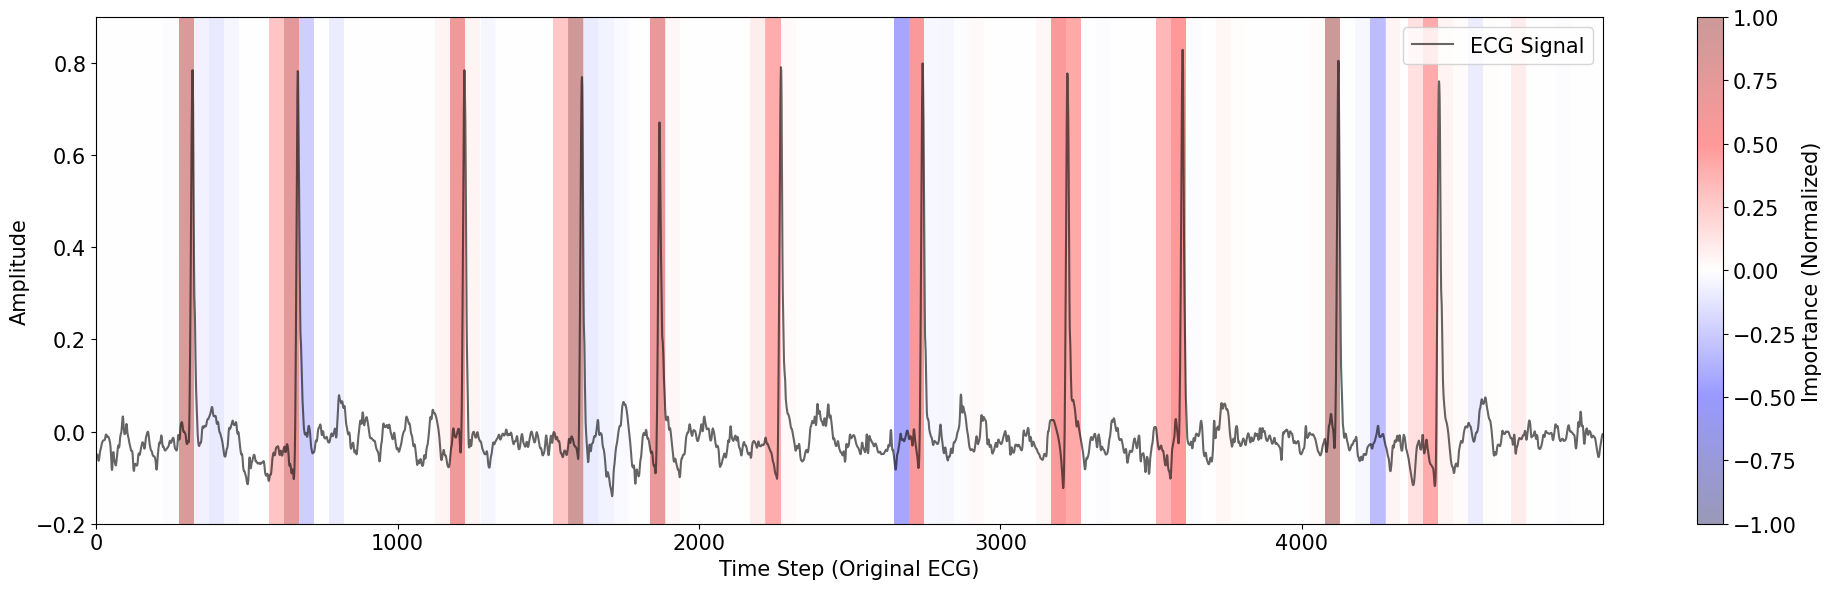

Attribution Range: -0.43172908865719456 to 1.0
Mean Abs Attribution: 0.11215143391977492
Actual label 3 - Atrial fibrillation. Predicted 3


array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
# 1. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
run_lime(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


In [ ]:
# {'A': 0,
#  'C': 1,
#  'D': 2,
#  'E': 3,
#  'F': 4,
#  'H': 5,
#  'I': 6,
#  'J': 7,
#  'K': 8,
#  'L': 9,
#  'M': 10})

torch.Size([1, 12, 5000])
torch.Size([1, 5000, 12])
Total LIME features generated: 100
Computing LIME attributions...


Lime attribution:   0%|          | 0/103 [00:00<?, ?it/s]

Lime attribution: 100%|██████████| 103/103 [00:57<00:00,  1.80it/s]


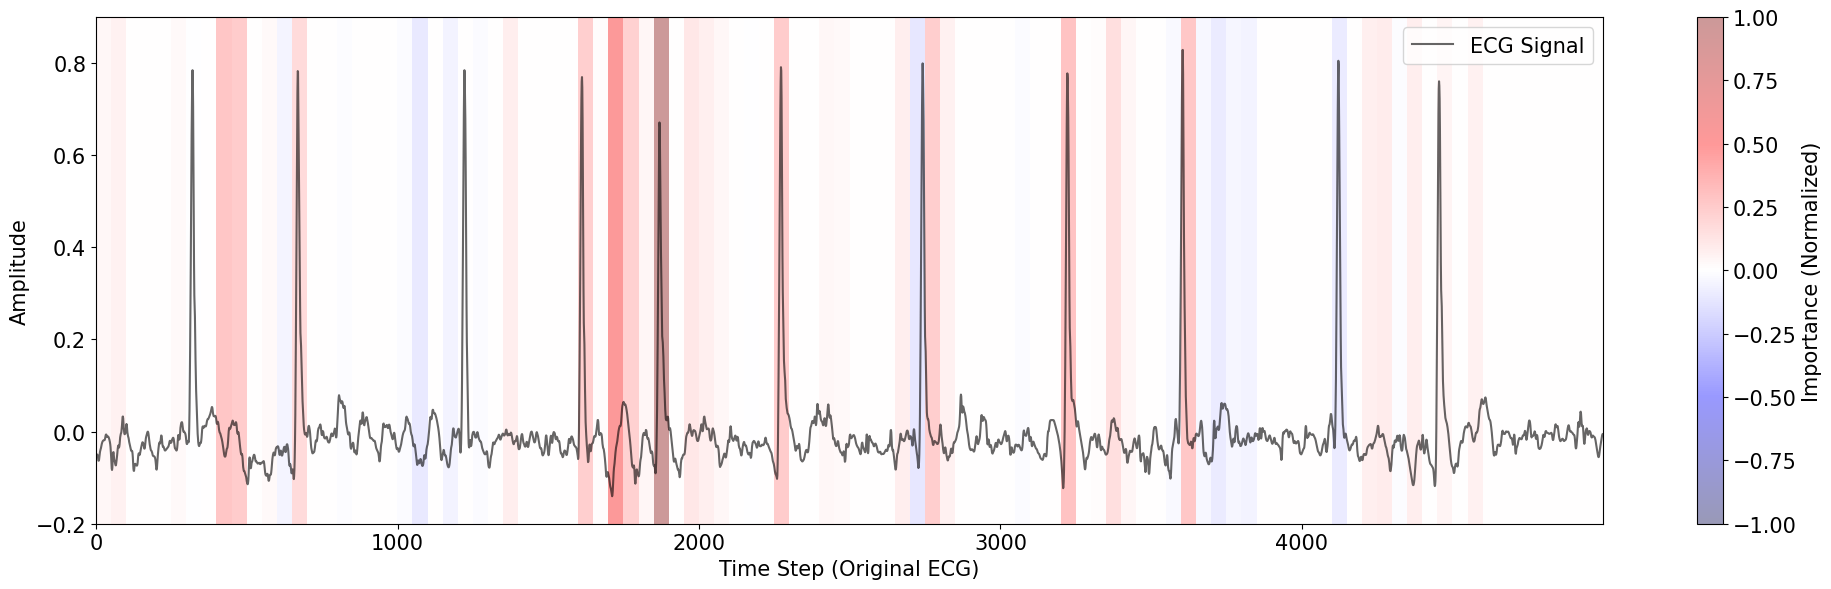

Attribution Range: -0.11302398145198822 to 1.0
Mean Abs Attribution: 0.05788605287671089
Actual label 3 - Atrial fibrillation. Predicted 3


In [19]:
# 1. CATNET
catnet_model.eval()
catnet_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)       # (1, 12, 5000)
x = x.transpose(1, 2)    # (1, Channels, 5000)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

catnet_lime_attr = run_lime(catnet_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 12, 5000])
Total LIME features generated: 100
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [04:13<00:00,  2.47s/it]


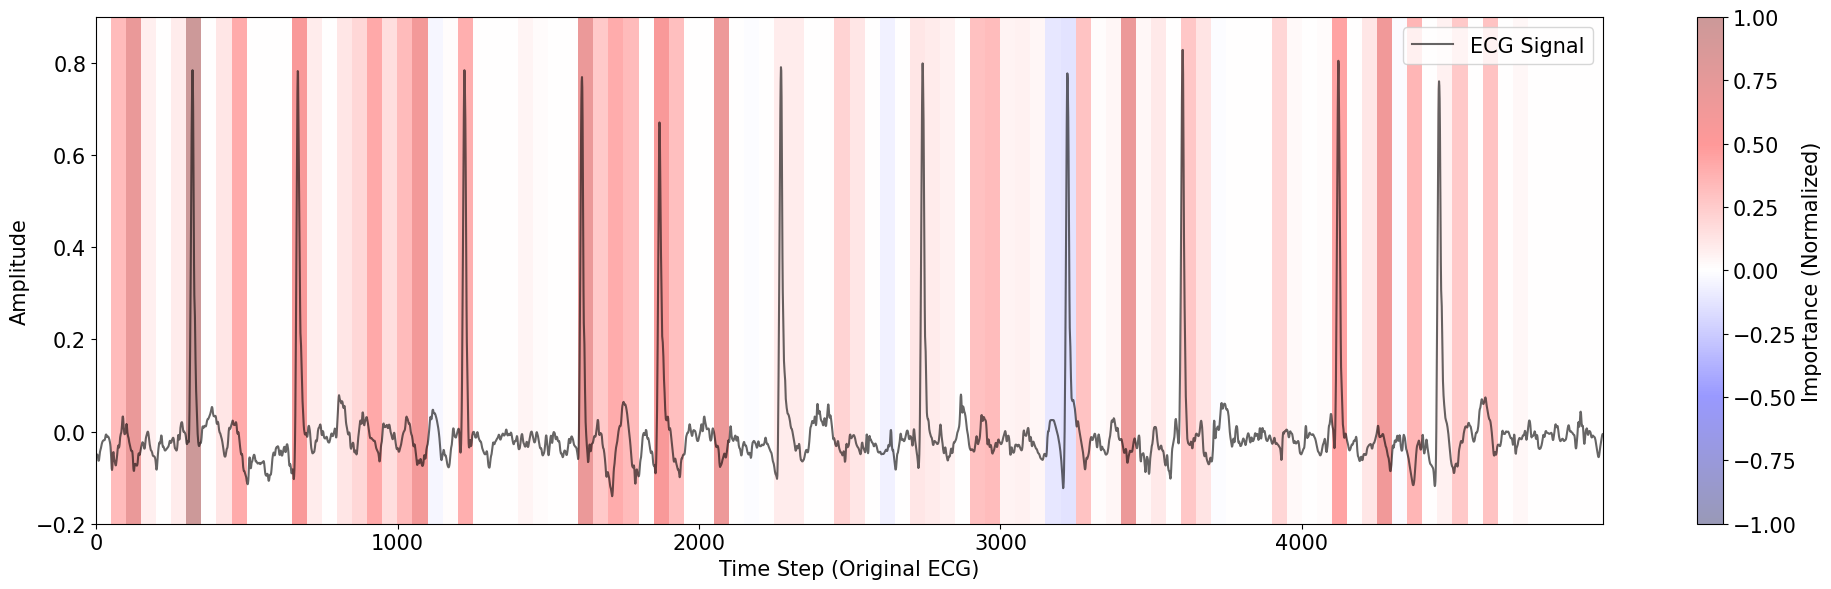

Attribution Range: -0.13994918763637543 to 1.0
Mean Abs Attribution: 0.14898371696472168
Actual label 3 - Atrial fibrillation. Predicted 3


In [20]:
# 2. LIGHTX3ECG
lightx3ecg_model.eval()
lightx3ecg_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

lightx3cg_lime_attr = run_lime(lightx3ecg_model, x, y_true_description, y_true, 'zero')

Total LIME features generated: 102
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:23<00:00,  1.23it/s]


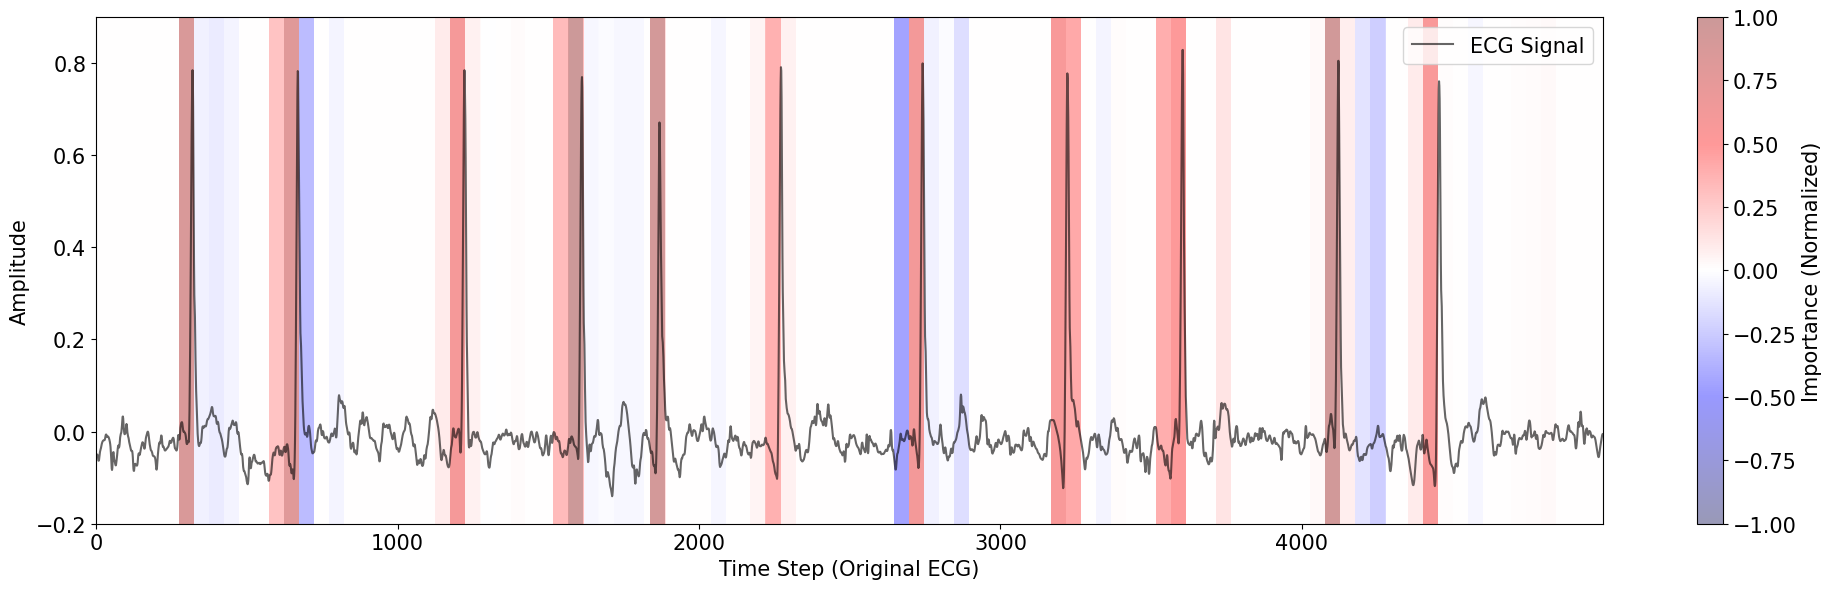

Attribution Range: -0.45196103332036863 to 1.0
Mean Abs Attribution: 0.11852571798049953
Actual label 3 - Atrial fibrillation. Predicted 3


In [13]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  
x = x.unsqueeze(0)
# print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500) 
han_lime_attr = run_lime(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import torch.nn.functional as F
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def run_ig_sum(model, x, y_true_description, y_true, baseline='zero', full=None, r_peaks=None, pre_samples=99, post_samples=201, window_size=50):
    set_seed(10)
    is_4d = len(x.shape) == 4
    if is_4d:
        model.train()
    else: 
        model.eval()
    device = x.device

    # -----------------------------
    # Model wrapper
    # -----------------------------
    def model_forward(input_tensor):
        return model(input_tensor)

    # Predict class
    with torch.no_grad():
        y_pred = torch.argmax(model_forward(x), dim=1).item()

    # -----------------------------
    # Baseline
    # -----------------------------
    if baseline == 'zero':
        baselines = torch.zeros_like(x)
    elif baseline == 'noise':
        baselines = torch.randn_like(x) * 0.01
    else:
        raise ValueError(f"Unknown baseline: {baseline}")

    # -----------------------------
    # Compute Integrated Gradients
    # -----------------------------
    ig = IntegratedGradients(model_forward)
    print("Computing Integrated Gradients attributions...")
    attributions, _ = ig.attribute(
        inputs=x,
        baselines=baselines,
        target=y_pred,
        return_convergence_delta=True
    )

    # -----------------------------
    # Plotting
    # -----------------------------
    lead_idx = 1  # Lead II

    if is_4d and full is not None and r_peaks is not None:
        # 4D beats → map back to full ECG
        full_len = full.shape[2]
        attr_full = np.zeros(full_len)
        ecg_full = full[0, lead_idx, :].cpu().detach().numpy()

        beat_len = x.shape[2]
        for i, peak in enumerate(r_peaks):
            start = max(0, peak - pre_samples)
            end = min(full_len, peak + post_samples)
            beat_attr = attributions[0, i, :, lead_idx].cpu().detach().numpy()

            # Interpolate to match the window
            beat_attr_interp = np.interp(np.arange(end - start),
                                        np.linspace(0, end - start, len(beat_attr)),
                                        beat_attr)
            attr_full[start:end] = beat_attr_interp

        # Aggregate over window_size samples
        attr_aggregated = aggregate_attributions(attr_full, window_size)
        
        # Expand aggregated attributions back to full resolution for plotting
        attr_expanded = np.repeat(attr_aggregated, window_size)
        # Trim to match original length
        attr_expanded = attr_expanded[:len(ecg_full)]
        
        attr_norm = attr_expanded / np.max(np.abs(attr_expanded)) if np.max(np.abs(attr_expanded)) > 0 else attr_expanded
        time_steps = np.arange(len(ecg_full))

    else:
        # Full ECG input (3D)
        if x.shape[1] == 12:  # channels-first
            ecg_full = x[0, lead_idx, :].cpu().detach().numpy()
            attr_full = attributions[0, lead_idx, :].cpu().detach().numpy()
        else:  # channels-last
            ecg_full = x[0, :, lead_idx].cpu().detach().numpy()
            attr_full = attributions[0, :, lead_idx].cpu().detach().numpy()
        
        # Aggregate over window_size samples
        attr_aggregated = aggregate_attributions(attr_full, window_size)
        
        # Expand aggregated attributions back to full resolution for plotting
        attr_expanded = np.repeat(attr_aggregated, window_size)
        # Trim to match original length
        attr_expanded = attr_expanded[:len(ecg_full)]
        
        attr_norm = attr_expanded / np.max(np.abs(attr_expanded)) if np.max(np.abs(attr_expanded)) > 0 else attr_expanded
        time_steps = np.arange(len(ecg_full))

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(time_steps, ecg_full, 'k-', alpha=0.6, label='ECG Signal')
    
    im = ax.pcolormesh([time_steps, time_steps],
                       [np.min(ecg_full), np.max(ecg_full)],
                       [attr_norm, attr_norm],
                       cmap='seismic',
                       alpha=0.4,
                       vmin=-1, vmax=1)
    
    # --- FONT SIZE UPDATES ---
    plt.xlabel("Time Step (Original ECG)", fontsize=15)
    plt.ylabel("Amplitude", fontsize=15)
    plt.legend(fontsize=15)
    
    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Colorbar configuration with font sizes
    cbar = plt.colorbar(im)
    cbar.set_label("Importance (Normalized)", fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    # --- RANGE LIMIT ---
    ax.set_ylim(-0.2, 0.9)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Debugging stats
    # -----------------------------
    print(f"Attribution Range: {attr_norm.min()} to {attr_norm.max()}")
    print(f"Mean Abs Attribution: {np.mean(np.abs(attr_norm))}")
    print(f"Number of windows: {len(attr_aggregated)}")
    print(f"Window size: {window_size} samples")
    print(f"Actual label {y_true} - {y_true_description}. Predicted {y_pred}")
    return attr_expanded


def aggregate_attributions(attr, window_size):
    n_windows = len(attr) // window_size
    # Truncate to fit complete windows
    attr_truncated = attr[:n_windows * window_size]
    # Reshape and sum over each window
    attr_reshaped = attr_truncated.reshape(n_windows, window_size)
    return np.sum(attr_reshaped, axis=1)


def aggregate_signal(signal, window_size):
    n_windows = len(signal) // window_size
    # Truncate to fit complete windows
    signal_truncated = signal[:n_windows * window_size]
    # Reshape and average over each window
    signal_reshaped = signal_truncated.reshape(n_windows, window_size)
    return np.mean(signal_reshaped, axis=1)

torch.Size([1, 12, 5000])
Computing Integrated Gradients attributions...


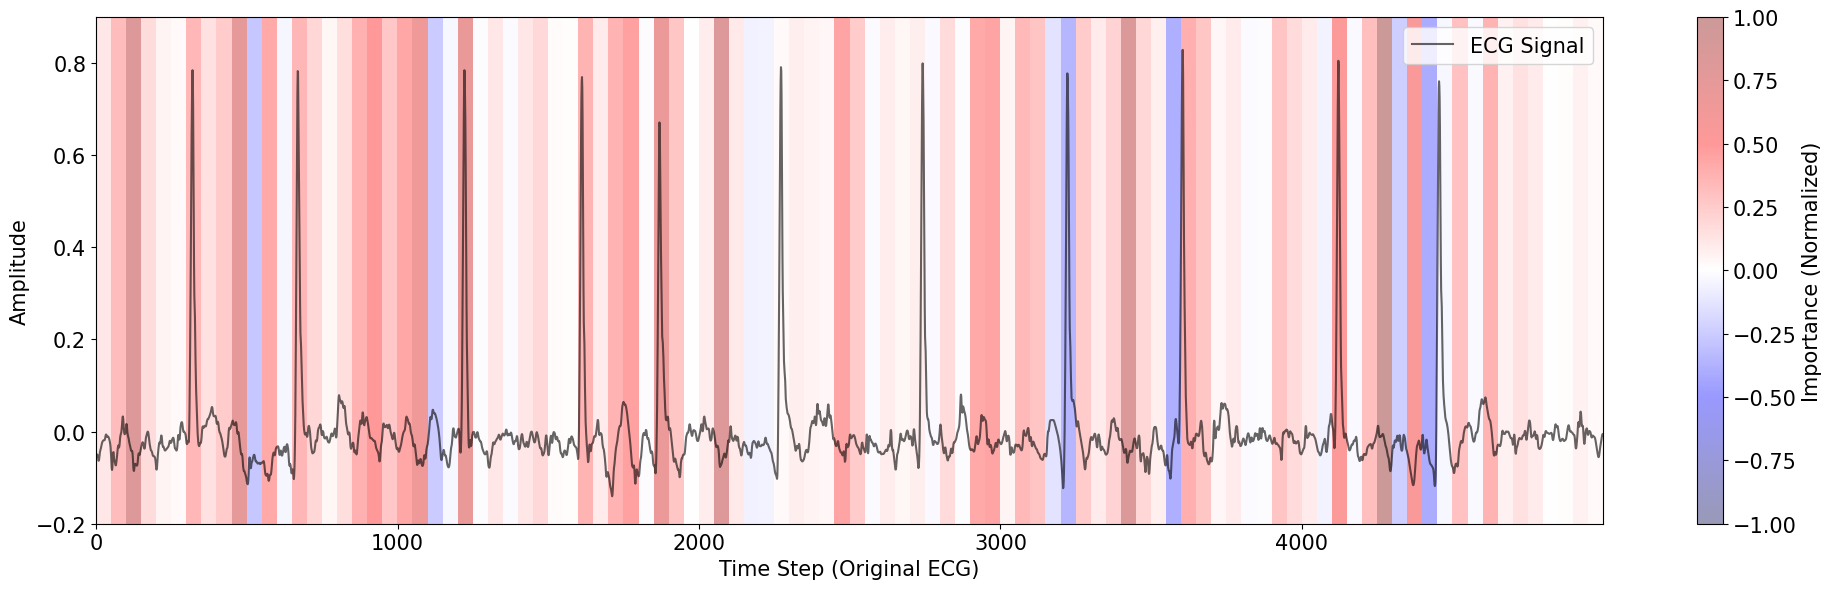

Attribution Range: -0.40104588866233826 to 1.0
Mean Abs Attribution: 0.22707881033420563
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [ ]:
# 1. LIGHTX3ECG
lightx3ecg_model.eval()
lightx3ecg_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  
x = x[:, :5000]      
x = x.unsqueeze(0)  
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

lightx3ecg_ig_attr = run_ig_sum(lightx3ecg_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 12, 5000])
torch.Size([1, 5000, 12])
Computing Integrated Gradients attributions...


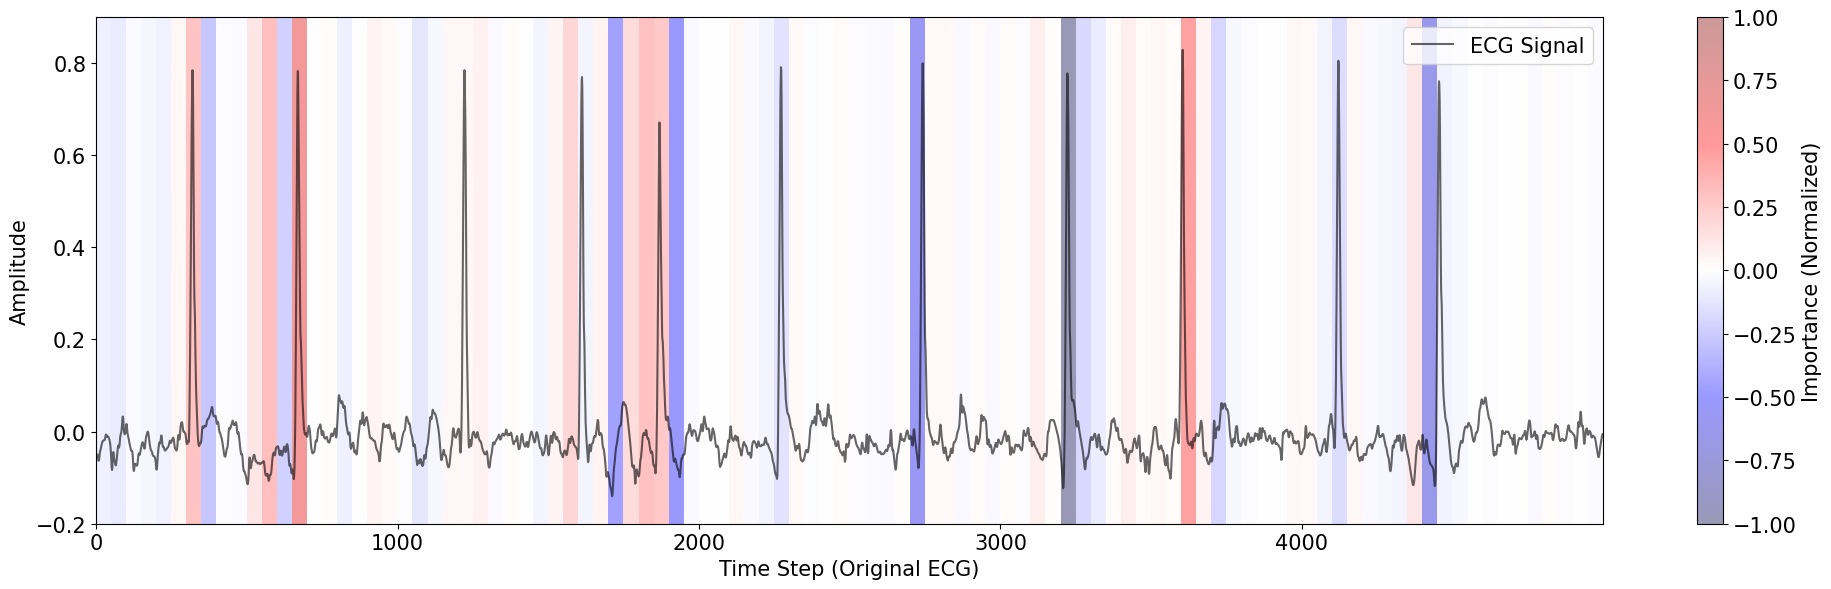

Attribution Range: -1.0 to 0.6051537394523621
Mean Abs Attribution: 0.09666110575199127
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [16]:
# 2. CATNET
catnet_model.eval()
catnet_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)       # (1, 12, 5000)
x = x.transpose(1, 2)    # (1, Channels, 5000)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

catnet_ig_attr = run_ig_sum(catnet_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 17, 300, 12])
Computing Integrated Gradients attributions...


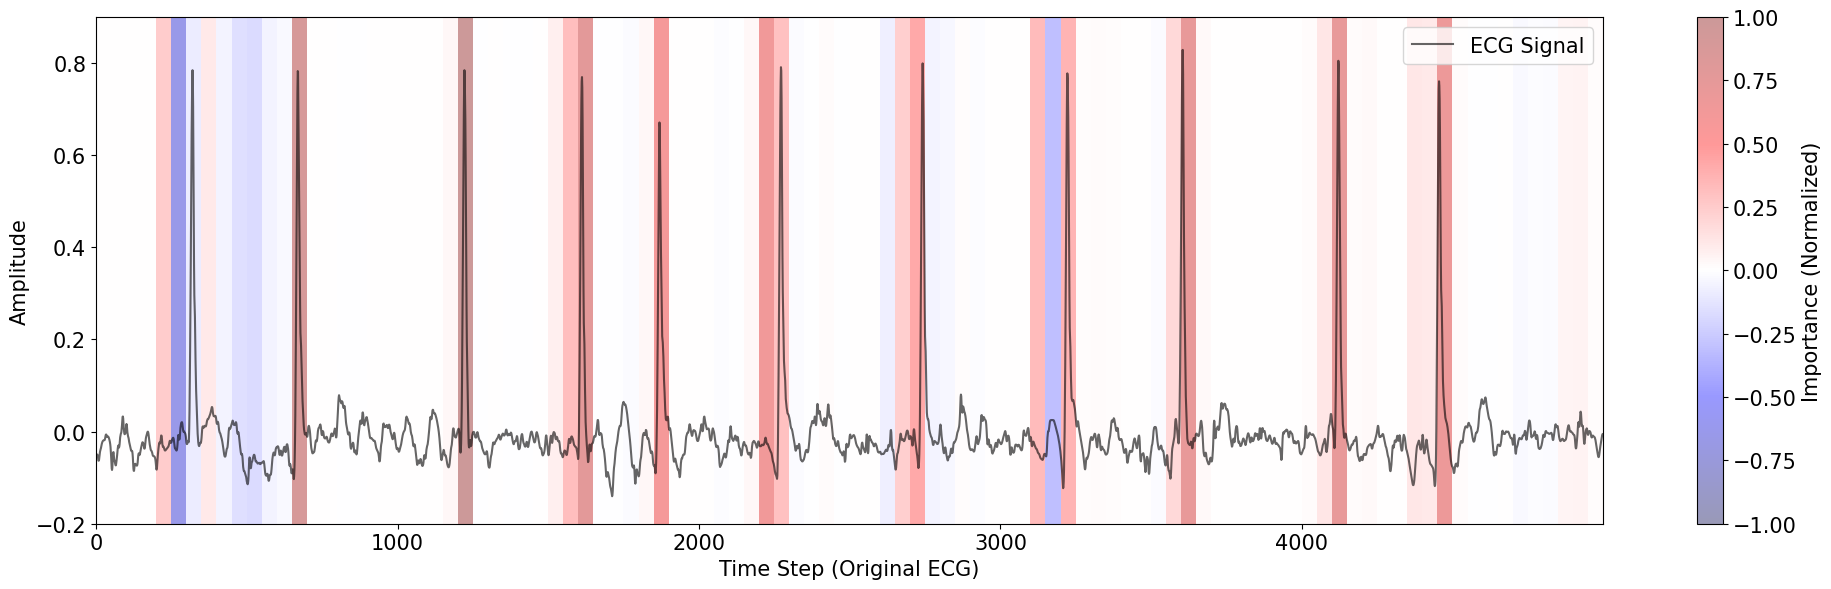

Attribution Range: -0.6466345695585004 to 1.0
Mean Abs Attribution: 0.11240342032958459
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [17]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
han_ig_attr = run_ig_sum(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


In [21]:
import numpy as np
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def calculate_agreement(attr_ig, attr_lime, threshold_percentile=20, plot=True):
   
    # 1. Consistency Check
    min_len = min(len(attr_ig), len(attr_lime))
    attr_ig = attr_ig[:min_len]
    attr_lime = attr_lime[:min_len]

    def normalize(a):
        m = np.max(np.abs(a))
        return a / m if m > 0 else a

    ig_norm = normalize(attr_ig)
    lime_norm = normalize(attr_lime)

    # Determine thresholds based on absolute magnitude distribution
    ig_thresh_val = np.percentile(np.abs(ig_norm), 100 - threshold_percentile)
    lime_thresh_val = np.percentile(np.abs(lime_norm), 100 - threshold_percentile)

    # Create Binary Masks (1 = Important, 0 = Unimportant/Zero)
    mask_ig = np.abs(ig_norm) > ig_thresh_val
    mask_lime = np.abs(lime_norm) > lime_thresh_val

    matches = (mask_ig == mask_lime)
    smc = np.sum(matches) / len(matches)

    results = {
        "Simple Matching Coeff (Overlap including 0s)": round(smc, 4),
        "Evaluated on top %": threshold_percentile
    }
    
    return results

metrics = calculate_agreement(catnet_ig_attr, catnet_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.8, 'Evaluated on top %': 20}


In [22]:

# Calculate metrics
metrics = calculate_agreement(han_ig_attr, han_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.8224, 'Evaluated on top %': 20}


In [23]:
metrics = calculate_agreement(lightx3ecg_ig_attr, lightx3cg_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.88, 'Evaluated on top %': 20}


In [ ]:
# Some failure analysis
for idx, sample in enumerate(samples):
    print(idx, torch.argmax(han_model(torch.tensor(sample['beats']).unsqueeze(0))))

0 tensor(3)
1 tensor(3)
2 tensor(3)
3 tensor(3)
4 tensor(3)
5 tensor(3)
6 tensor(3)
7 tensor(3)
8 tensor(3)
9 tensor(3)
10 tensor(3)
11 tensor(3)
12 tensor(3)
13 tensor(3)
14 tensor(3)
15 tensor(3)
16 tensor(3)
17 tensor(3)
18 tensor(3)
19 tensor(3)
20 tensor(3)
21 tensor(3)
22 tensor(3)
23 tensor(3)
24 tensor(3)
25 tensor(6)
26 tensor(3)
27 tensor(3)
28 tensor(3)
29 tensor(3)
30 tensor(3)
31 tensor(3)
32 tensor(3)
33 tensor(3)
34 tensor(3)
35 tensor(3)
36 tensor(3)
37 tensor(3)
38 tensor(3)
39 tensor(3)
40 tensor(3)
41 tensor(3)
42 tensor(3)
43 tensor(3)
44 tensor(3)
45 tensor(3)
46 tensor(3)
47 tensor(3)
48 tensor(3)
49 tensor(3)
50 tensor(3)
51 tensor(3)
52 tensor(3)
53 tensor(3)
54 tensor(3)
55 tensor(3)
56 tensor(3)
57 tensor(3)
58 tensor(3)
59 tensor(0)
60 tensor(3)
61 tensor(3)
62 tensor(3)
63 tensor(3)
64 tensor(3)
65 tensor(3)
66 tensor(3)
67 tensor(3)
68 tensor(3)
69 tensor(3)
70 tensor(3)
71 tensor(3)
72 tensor(3)
73 tensor(3)
74 tensor(3)
75 tensor(3)
76 tensor(3)
77 tensor

torch.Size([1, 14, 300, 12])
Total LIME features generated: 84
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:08<00:00,  1.51it/s]


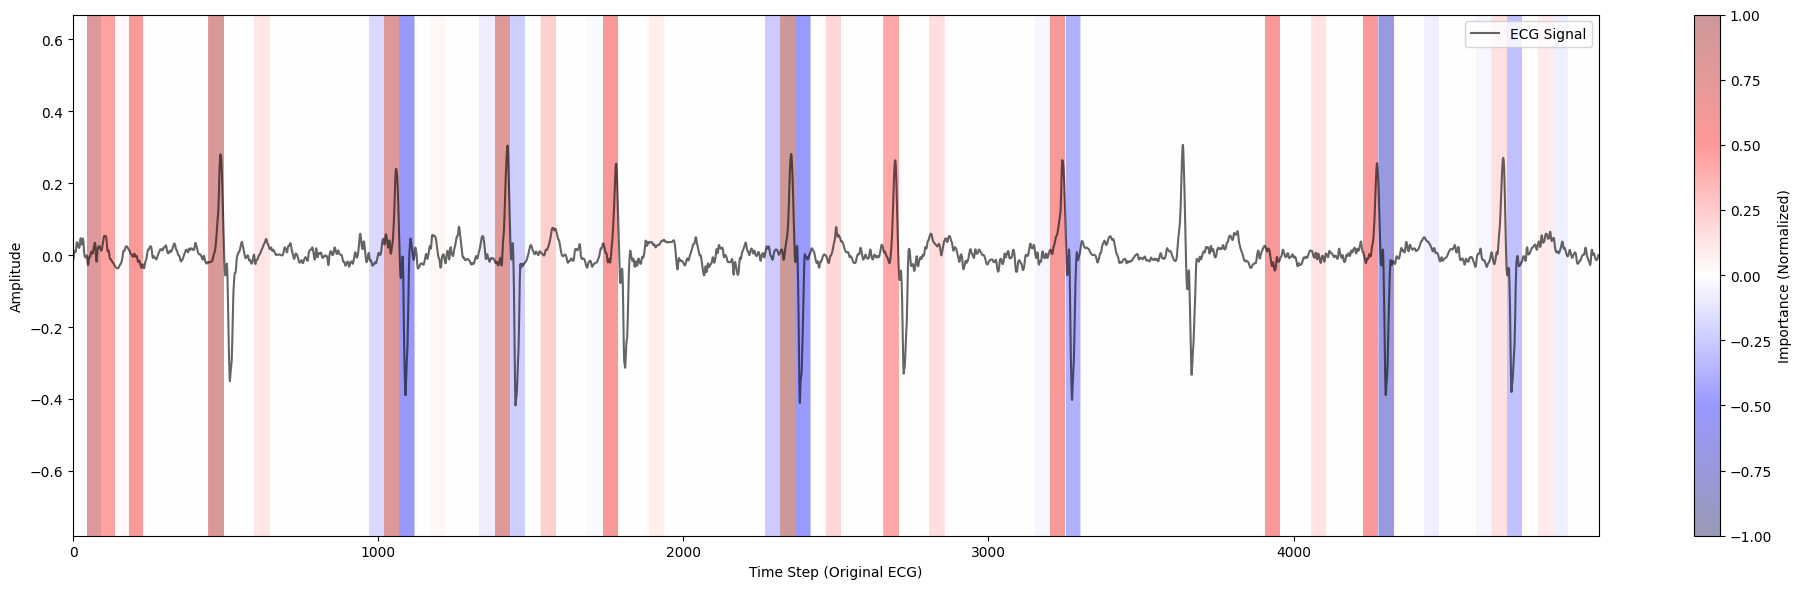

Attribution Range: -0.7332337491633218 to 1.0
Mean Abs Attribution: 0.12613983718033295
Actual label 3 - Atrial fibrillation. Predicted 7


In [21]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 248
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
han_lime_attr = run_lime(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)

torch.Size([1, 17, 300, 12])
Total LIME features generated: 102
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:37<00:00,  1.06it/s]


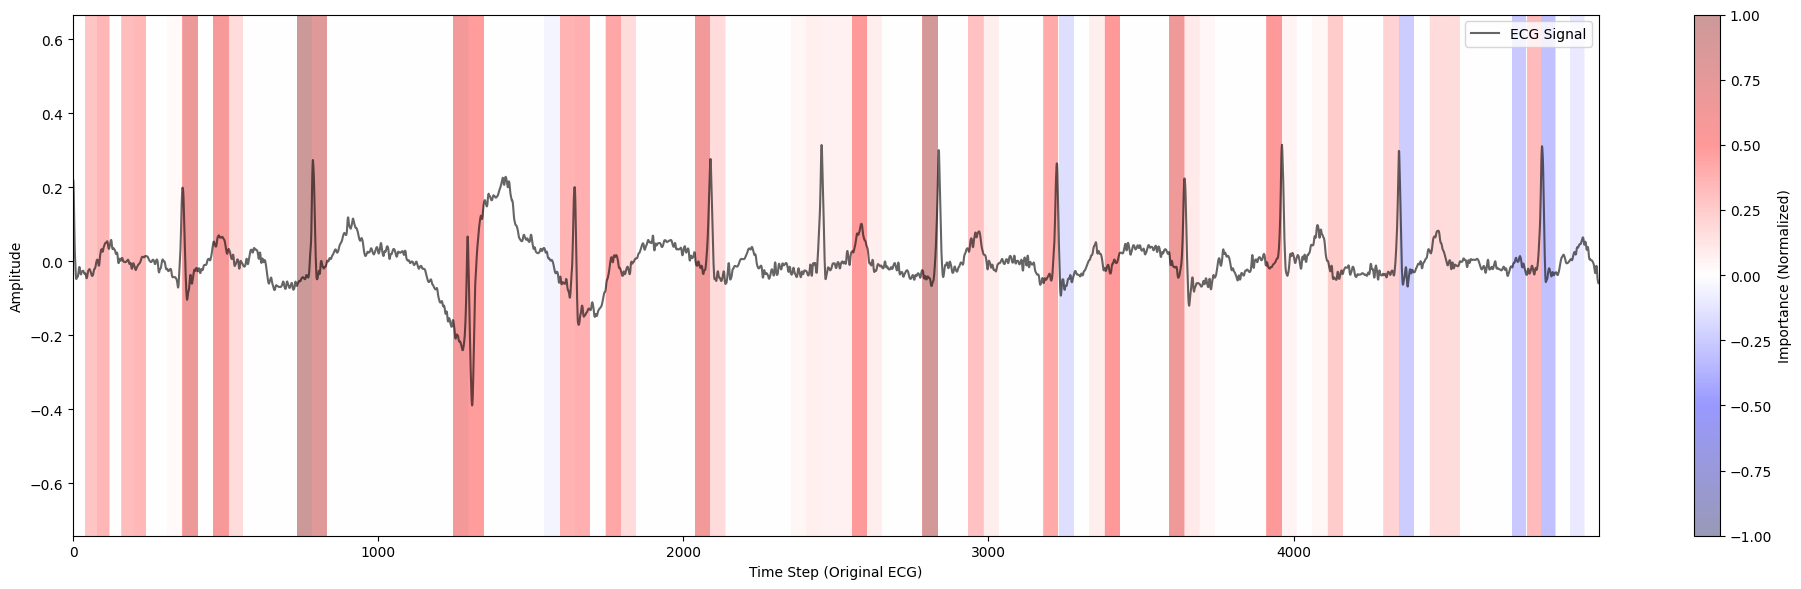

Attribution Range: -0.2975937752479116 to 1.0
Mean Abs Attribution: 0.14229537719722085
Actual label 3 - Atrial fibrillation. Predicted 0


In [23]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 59
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
han_lime_attr = run_lime(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)